In [102]:
import numpy as np
import pandas as pd

In [129]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

## Load datasets

In [104]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'

In [105]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

In [106]:
df_pca = pd.read_csv(dataset_path + dataset_name + dataset_pca_suffix + '.csv', index_col=0)
X_pca = df_pca.drop('type', axis=1)
y_pca = df_pca.type

### Oversampling

In [107]:
smt = SMOTE(random_state=42)
X_norm_res, y_norm_res = smt.fit_resample(X_norm, y_norm)
X_pca_res, y_pca_res = smt.fit_resample(X_pca, y_pca)

## Train

In [130]:
def train(X, y):
    # Train xgboost on the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Import grid search
    
    # Check best hyperparameters with grid search
    '''
    model = XGBClassifier()
    n_estimators = [100, 500, 1000]
    max_depth = [3, 4, 5, 6, 10]
    learning_rate = [0.0001, 0.001, 0.01, 0.1]
    param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=5, verbose=1)
    grid_result = grid_search.fit(X_train, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    '''


    # create model instance
    model = XGBClassifier()
    # fit model
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return preds, y_test

In [131]:
norm_pred, norm_real = train(X_norm, y_norm)
pca_pred, norm_real = train(X_pca, y_pca)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [110]:
norm_res_pred, norm_res_real = train(X_norm_res, y_norm_res)
pca_res_pred, pca_res_real = train(X_pca_res, y_pca_res)

[00:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Results

In [112]:
# Original dataset
print('Accuracy of normalized dataset: ', accuracy_score(norm_pred, norm_real))
print('F1 Score of normalized dataset: ', f1_score(norm_pred, norm_real, average='weighted'))
print('Accuracy of PCA dataset: ', accuracy_score(pca_pred, norm_real))
print('F1 Score of PCA dataset: ', f1_score(pca_pred, norm_real, average='weighted'))

Accuracy of normalized dataset:  0.9032258064516129
F1 Score of normalized dataset:  0.9034306195596519
Accuracy of PCA dataset:  0.8709677419354839
F1 Score of PCA dataset:  0.8664579148450117


In [113]:
# Oversampled dataset
print('Accuracy of normalized oversampled dataset: ', accuracy_score(norm_res_pred, norm_res_real))
print('F1 Score of normalized oversampled dataset: ', f1_score(norm_res_pred, norm_res_real, average='weighted'))
print('Accuracy of PCA oversampled dataset: ', accuracy_score(pca_res_pred, pca_res_real))
print('F1 Score of PCA oversampled dataset: ', f1_score(pca_res_pred, pca_res_real, average='weighted'))

Accuracy of normalized oversampled dataset:  0.98
F1 Score of normalized oversampled dataset:  0.9796791443850268
Accuracy of PCA oversampled dataset:  0.94
F1 Score of PCA oversampled dataset:  0.9415480519480519


## Plot

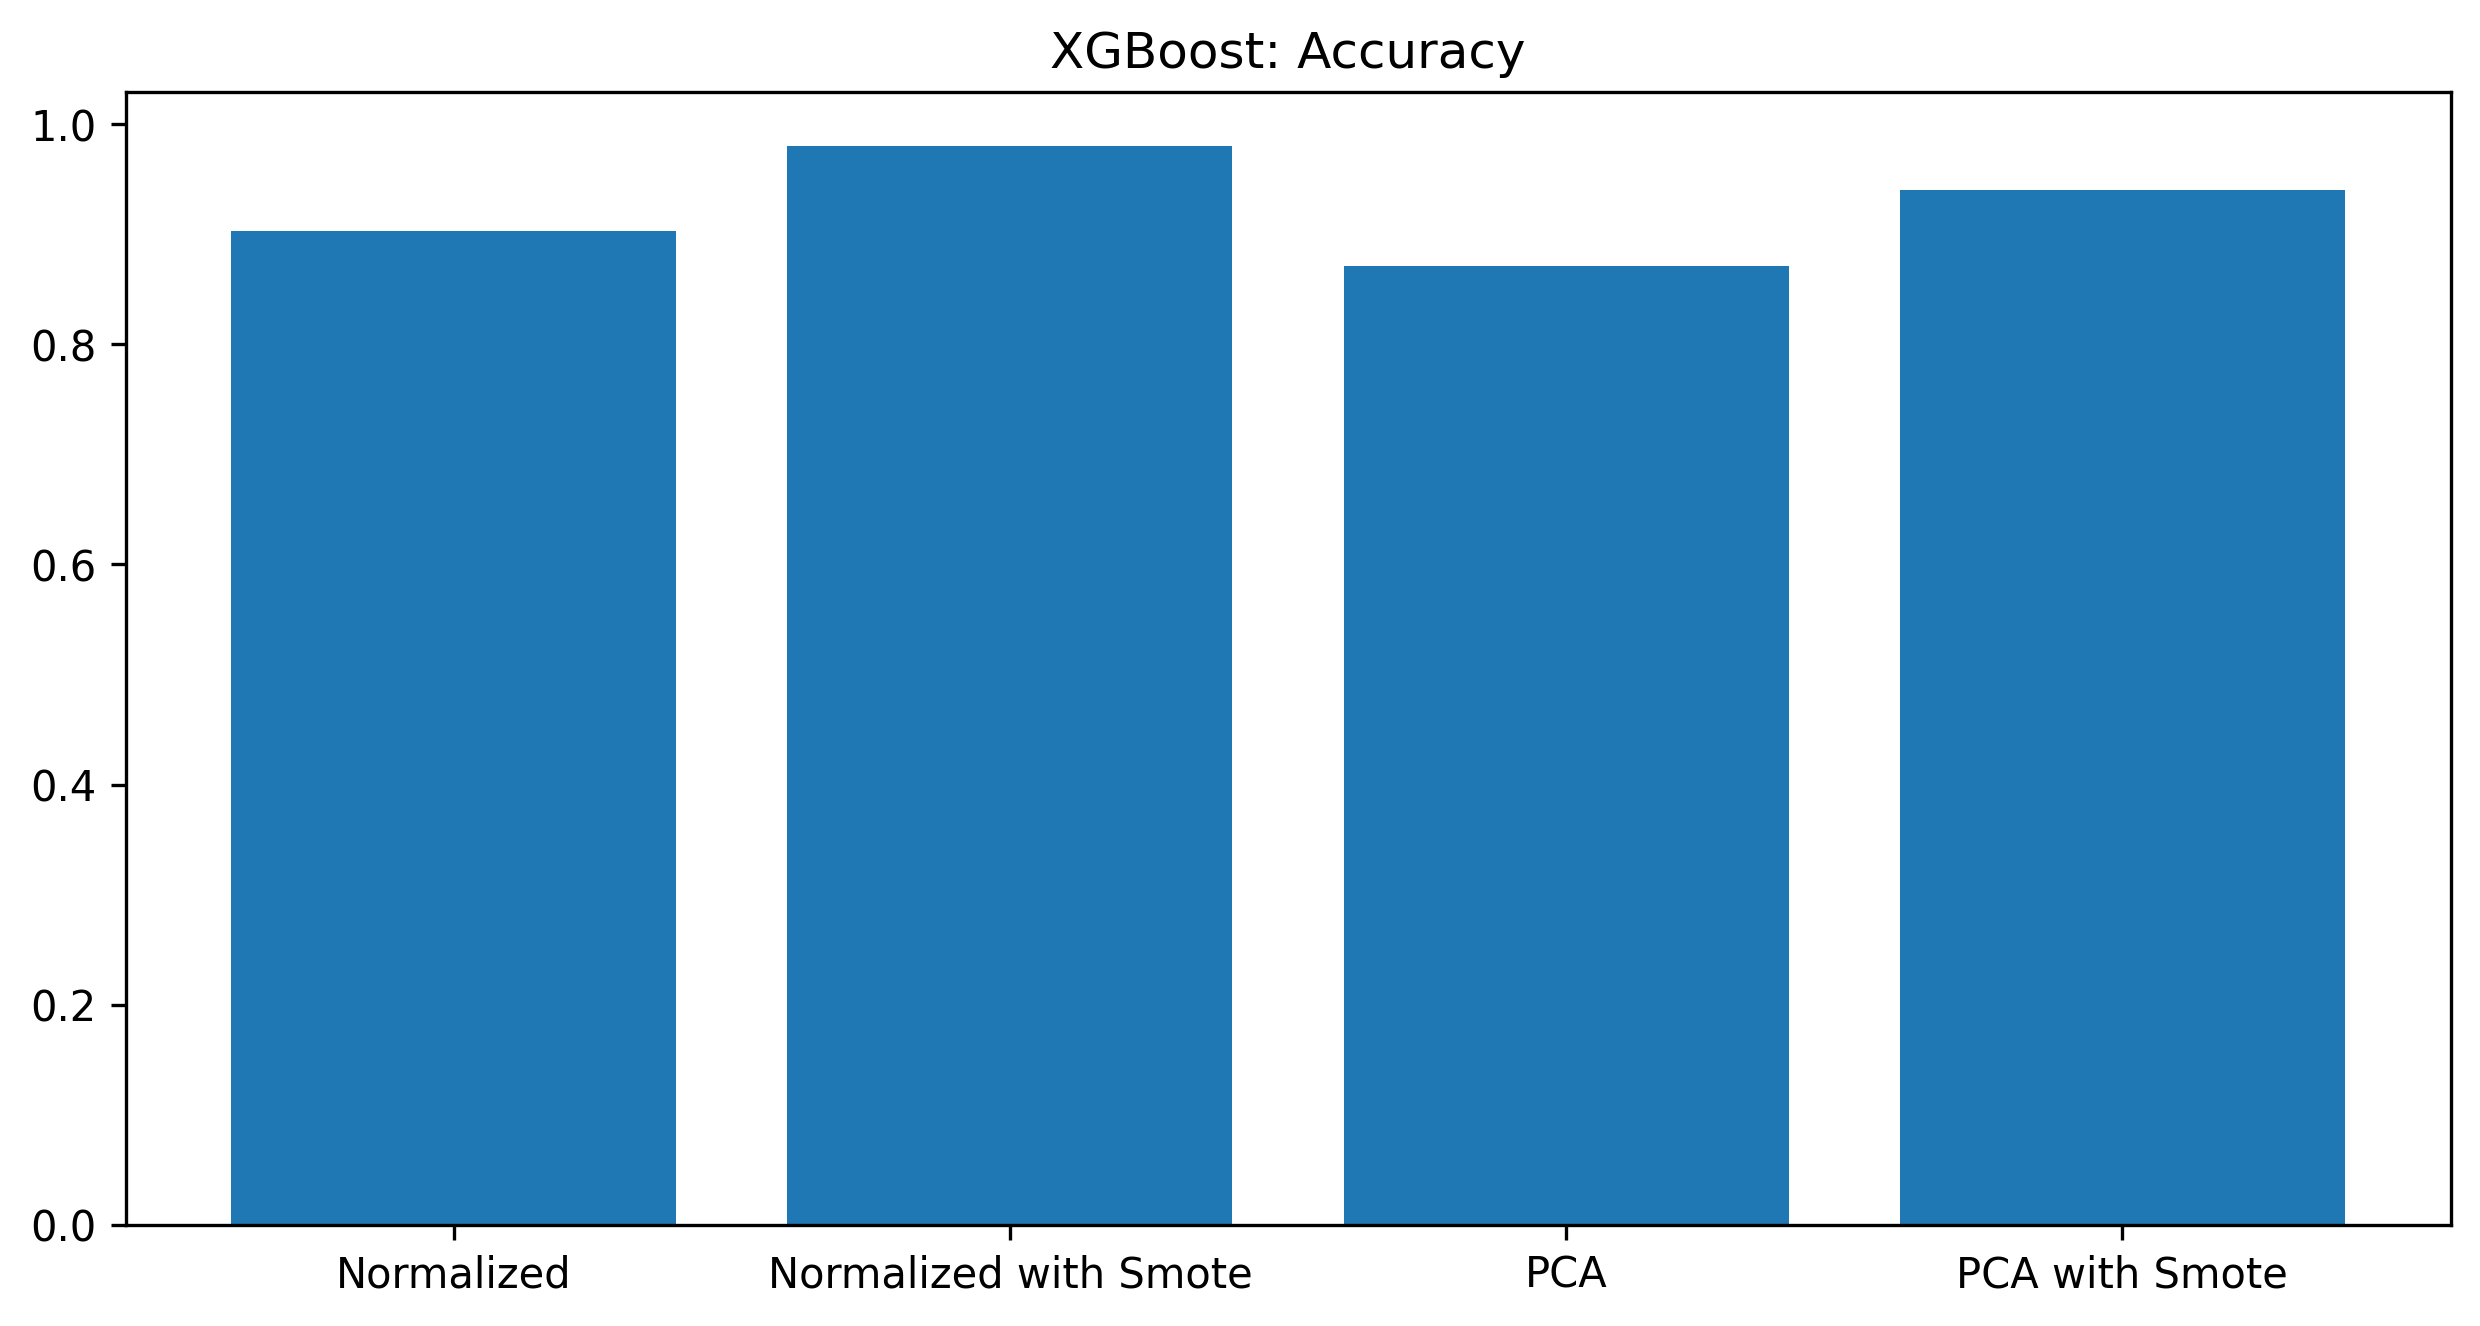

In [124]:
# Plot accuracy

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        accuracy_score(norm_pred, norm_real), 
        accuracy_score(norm_res_pred, norm_res_real), 
        accuracy_score(pca_pred, norm_real), 
        accuracy_score(pca_res_pred, pca_res_real)
    ]
)
plt.title('XGBoost: Accuracy')
plt.show()

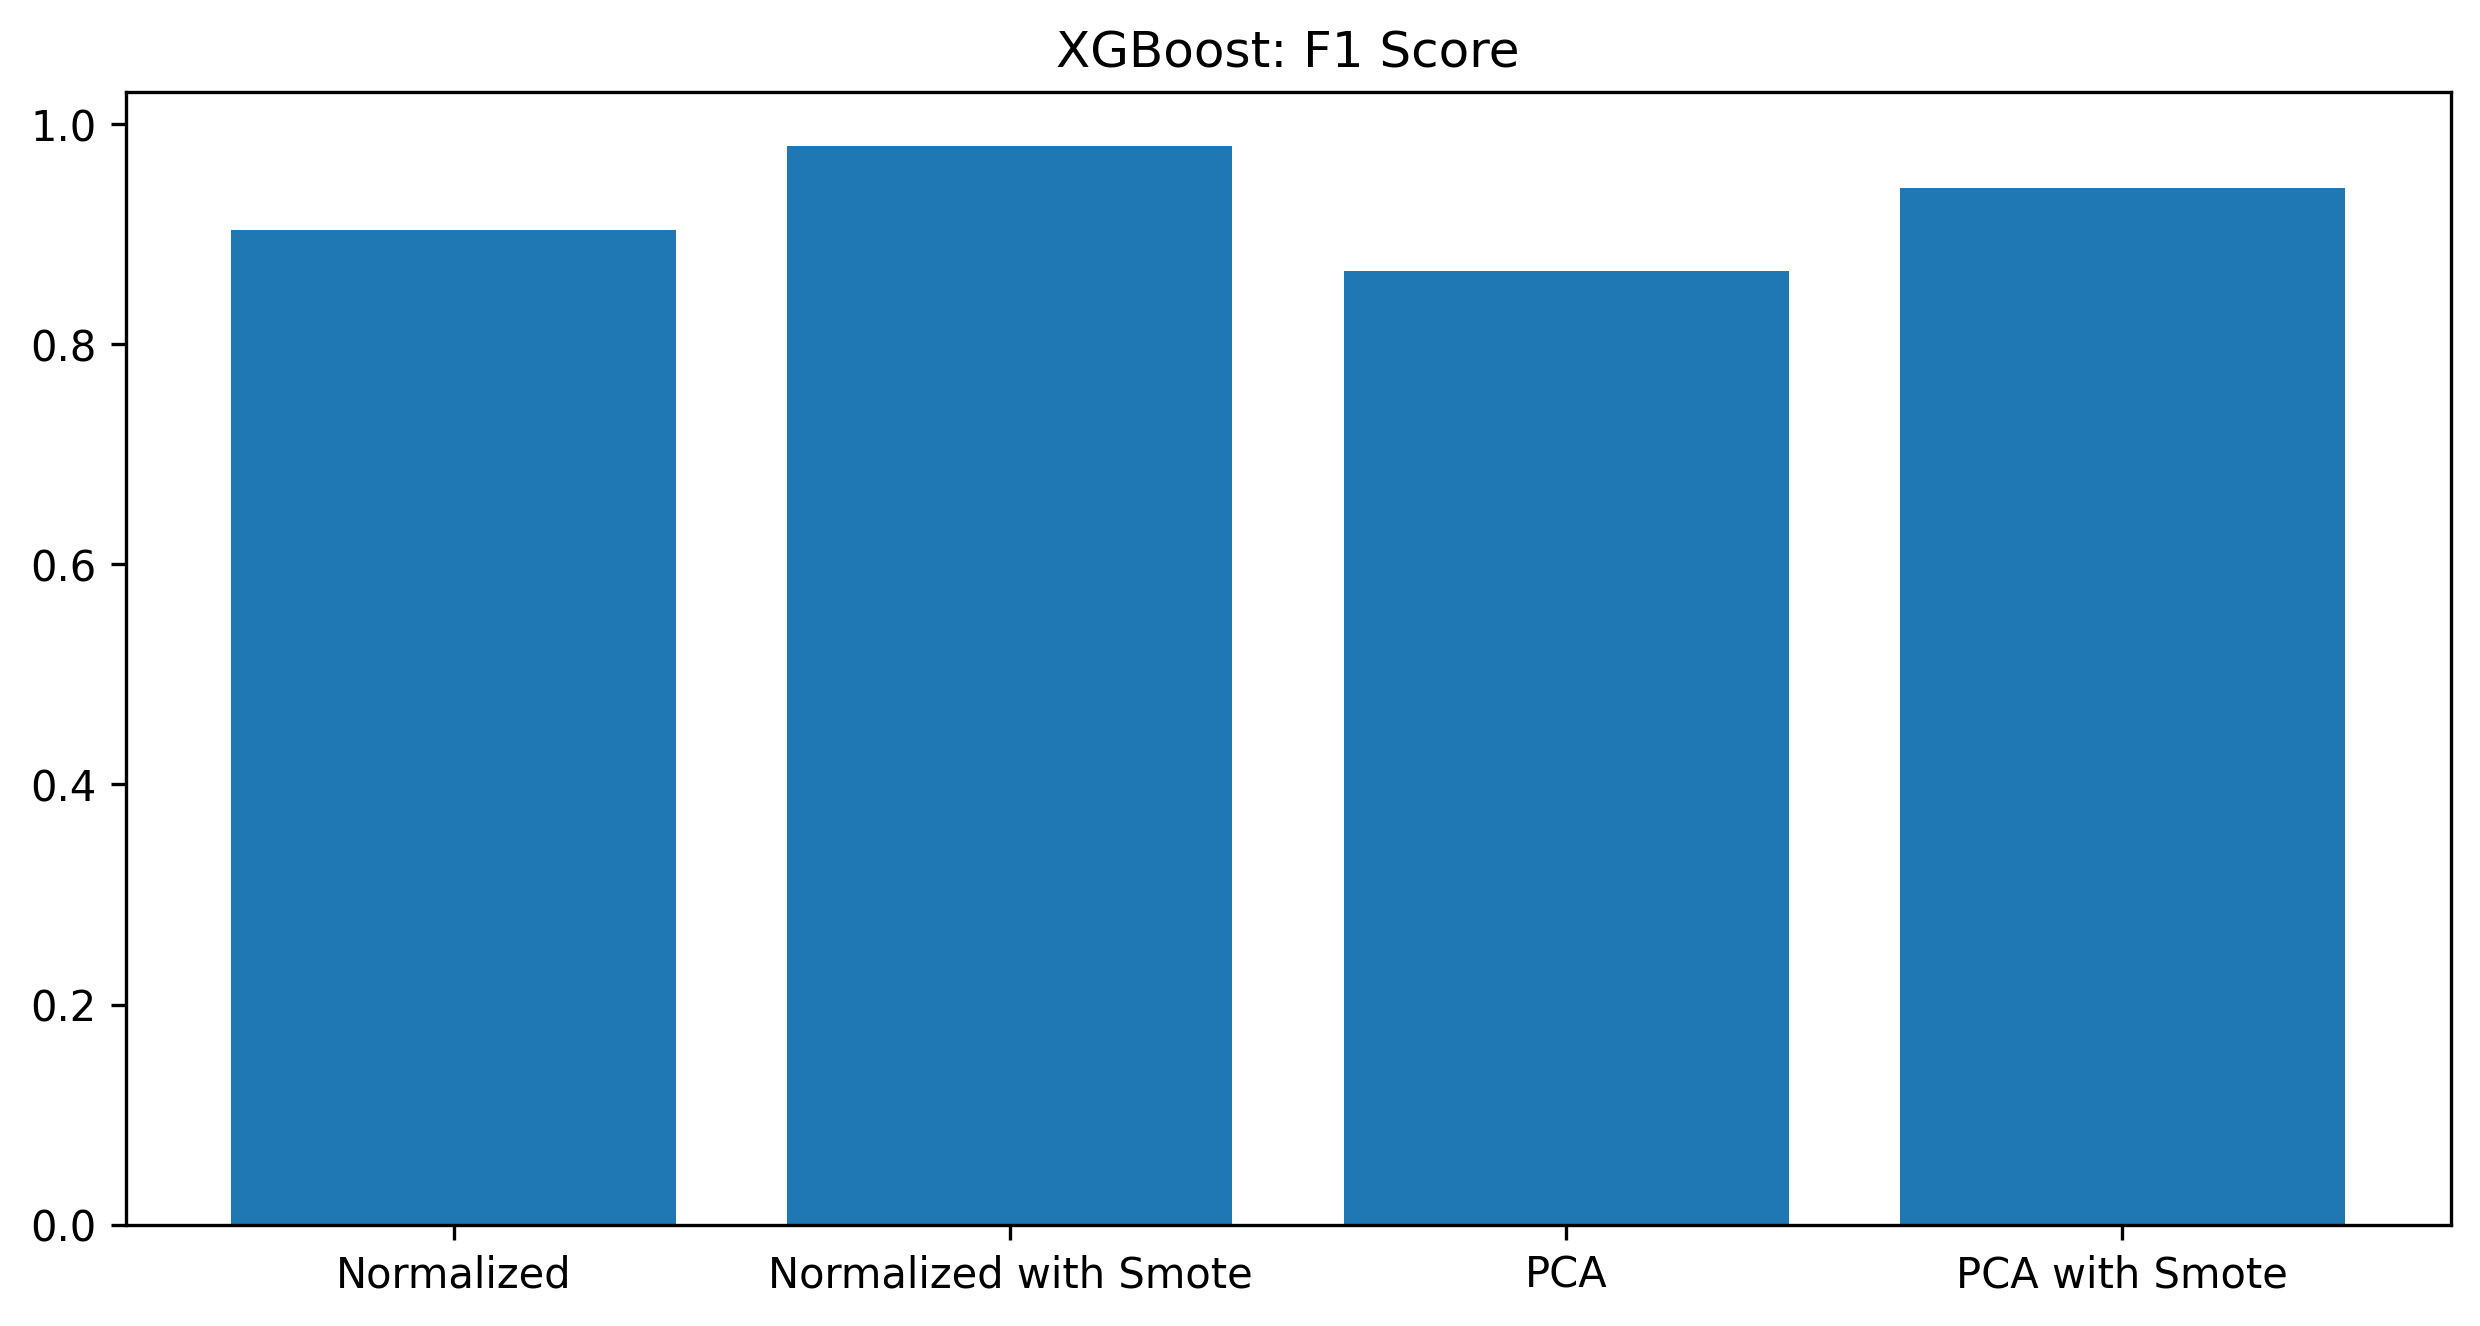

In [125]:
# Plot F1 score

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        f1_score(norm_pred, norm_real, average='weighted'), 
        f1_score(norm_res_pred, norm_res_real, average='weighted'), 
        f1_score(pca_pred, norm_real, average='weighted'), 
        f1_score(pca_res_pred, pca_res_real, average='weighted')
    ]
)
plt.title('XGBoost: F1 Score')
plt.show()